### Latency Comparison Script

This script compares the performance between two sites (GitHub Pages and Netlify), accurately measuring:

1. TTFB (Time To First Byte): time until the first response byte.
2. Download Time: time between TTFB and the end of loading.
3. Total Response Time: total request time.


In [12]:
import pycurl
import io
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# This section defines the URLs to be tested, the number of test repetitions,
# and initializes the results dictionary to store timing metrics for each site
urls = {
    "GitHub Pages": "https://jesseburlamaque.github.io/shp2leaflet/",
    "Netlify": "https://shp2leaflet.netlify.app/"
}

n_tests = 30

results = {
    name: {
        "dns": [],
        "connect": [],
        "ttfb": [],
        "download_time": [],
        "total": []
    }
    for name in urls
}

In [14]:
# Function to measure timing metrics for a given URL using pycurl
def test_url(url):
    buffer = io.BytesIO()
    c = pycurl.Curl()
    c.setopt(c.URL, url)
    c.setopt(c.WRITEFUNCTION, buffer.write)
    c.setopt(c.FOLLOWLOCATION, True)
    c.setopt(c.NOPROGRESS, True)
    c.setopt(c.CONNECTTIMEOUT, 10)
    c.setopt(c.TIMEOUT, 15)
    
    c.perform()
    
    # Get DNS lookup, connection, TTFB, download, and total times
    dns = c.getinfo(pycurl.NAMELOOKUP_TIME)        # DNS lookup time
    connect = c.getinfo(pycurl.CONNECT_TIME)       # Connection time
    ttfb = c.getinfo(pycurl.STARTTRANSFER_TIME)    # Time To First Byte
    total = c.getinfo(pycurl.TOTAL_TIME)           # Total response time
    download_time = total - ttfb                   # Download time (after TTFB)

    c.close()
    return dns, connect, ttfb, download_time, total

In [15]:
# This section collects timing metrics for each site by repeatedly testing their URLs. 
# For each attempt, it measures DNS lookup, connection, TTFB, download, and total response times, 
# storing the results for later analysis and plotting.

for name, url in urls.items():
    print(f"\n🔍 Testing: {name}")
    for i in range(n_tests):
        try:
            dns, connect, ttfb, download_time, total = test_url(url)
            results[name]["dns"].append(dns)
            results[name]["connect"].append(connect)
            results[name]["ttfb"].append(ttfb)
            results[name]["download_time"].append(download_time)
            results[name]["total"].append(total)
            print(f"Attempt {i+1}: TTFB={ttfb:.3f}s | Download={download_time:.3f}s | Total={total:.3f}s")
        except Exception as e:
            print(f"Attempt {i+1} failed: {e}")
            for key in results[name]:
                results[name][key].append(None)


🔍 Testing: GitHub Pages
Attempt 1: TTFB=0.320s | Download=0.000s | Total=0.320s
Attempt 2: TTFB=0.172s | Download=0.000s | Total=0.172s
Attempt 3: TTFB=0.154s | Download=0.000s | Total=0.154s
Attempt 4: TTFB=0.156s | Download=0.000s | Total=0.156s
Attempt 5: TTFB=0.160s | Download=0.000s | Total=0.160s
Attempt 6: TTFB=0.162s | Download=0.001s | Total=0.162s
Attempt 7: TTFB=0.164s | Download=0.000s | Total=0.164s
Attempt 8: TTFB=0.157s | Download=0.000s | Total=0.157s
Attempt 9: TTFB=0.158s | Download=0.000s | Total=0.158s
Attempt 10: TTFB=0.158s | Download=0.000s | Total=0.158s
Attempt 11: TTFB=0.159s | Download=0.000s | Total=0.159s
Attempt 12: TTFB=0.154s | Download=0.000s | Total=0.154s
Attempt 13: TTFB=0.153s | Download=0.000s | Total=0.153s
Attempt 14: TTFB=0.163s | Download=0.000s | Total=0.163s
Attempt 15: TTFB=0.188s | Download=0.000s | Total=0.188s
Attempt 16: TTFB=0.165s | Download=0.000s | Total=0.165s
Attempt 17: TTFB=0.161s | Download=0.000s | Total=0.161s
Attempt 18: TTF

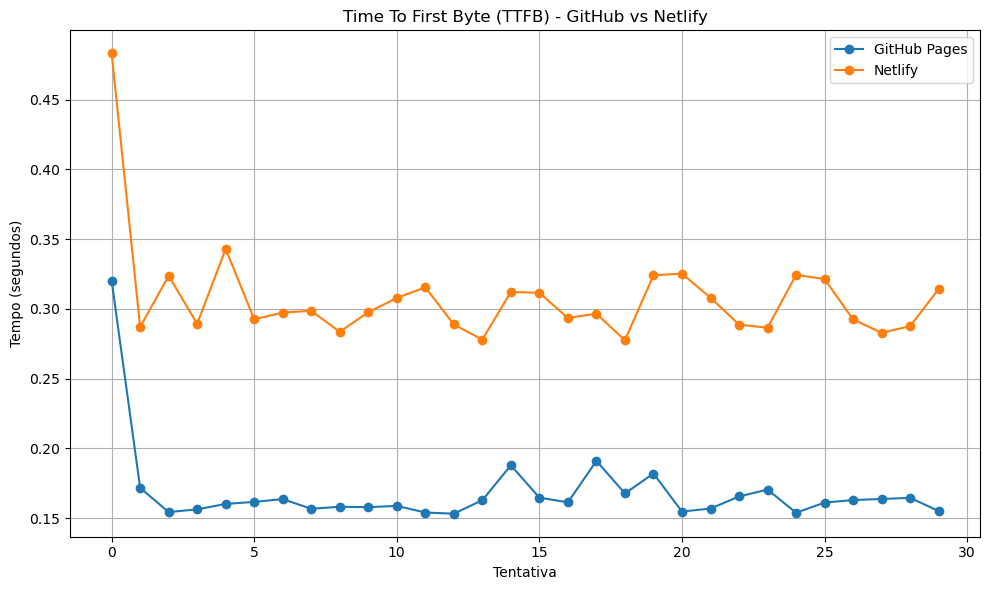

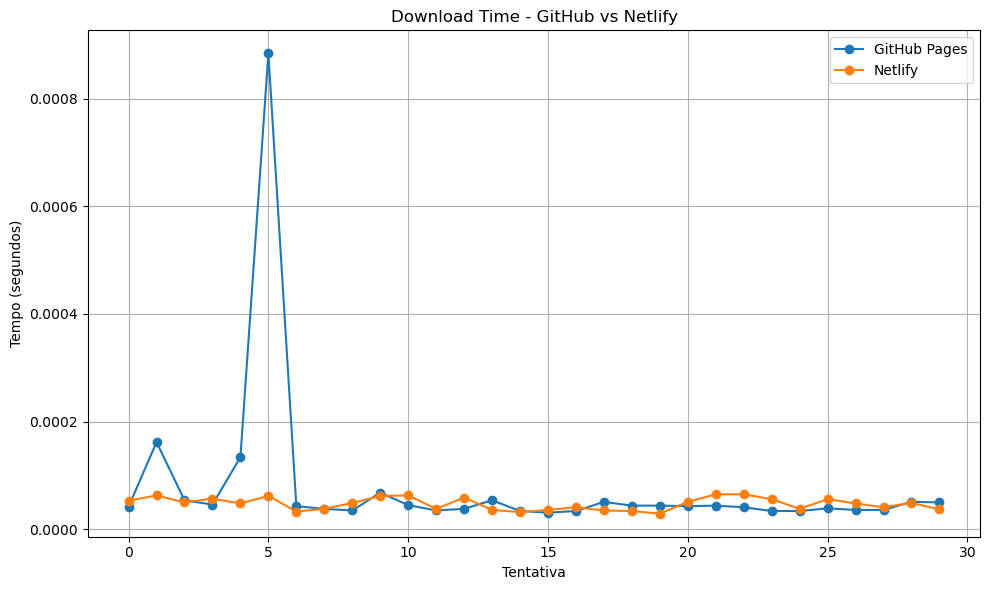

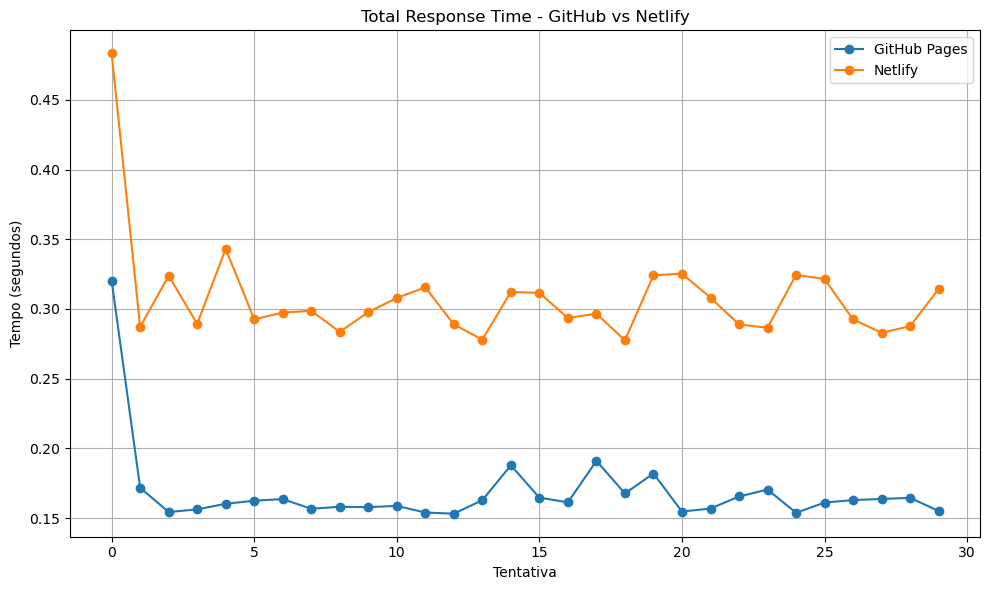

In [18]:
# Plotar cada métrica
metricas = {
    "ttfb": "Time To First Byte (TTFB)",
    "download_time": "Download Time",
    "total": "Total Response Time"
}

for metrica, titulo in metricas.items():
    plt.figure(figsize=(10, 6))
    for name in results:
        valores = [v for v in results[name][metrica] if v is not None]
        plt.plot(valores, label=name, marker='o')
    plt.title(titulo + " - GitHub vs Netlify")
    plt.xlabel("Tentativa")
    plt.ylabel("Tempo (segundos)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

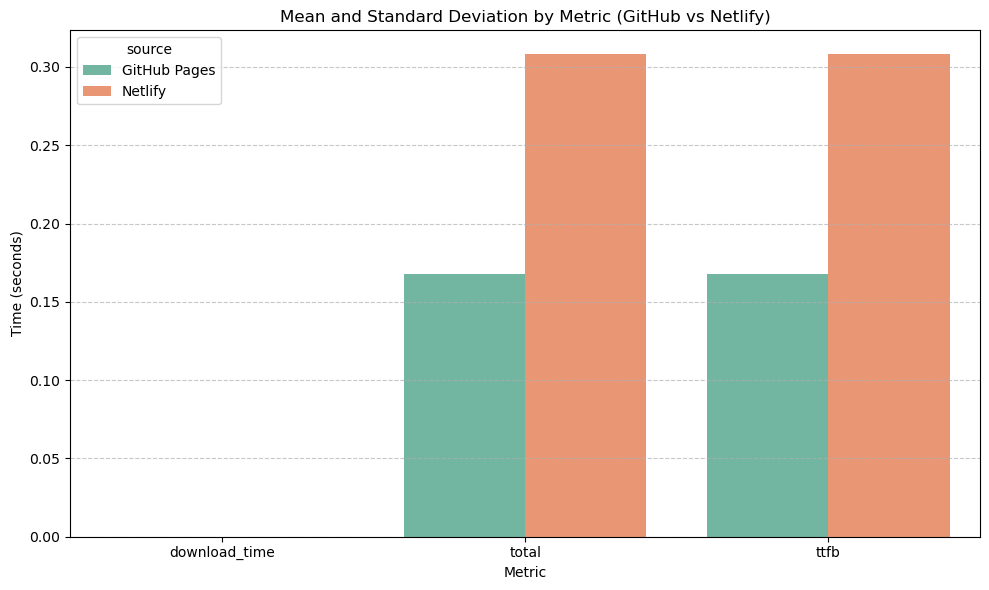


Summary statistics:
stat         metric        source   mean    std
0     download_time  GitHub Pages  0.000  0.000
1     download_time       Netlify  0.000  0.000
2             total  GitHub Pages  0.168  0.030
3             total       Netlify  0.308  0.037
4              ttfb  GitHub Pages  0.168  0.030
5              ttfb       Netlify  0.308  0.037


In [19]:
# Summary Statistics Analysis 

import pandas as pd
import seaborn as sns

# Build DataFrame with all results
dfs = []
for name, data in results.items():
    df = pd.DataFrame(data)
    df["source"] = name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# Compute mean and standard deviation by metric and source
summary = df_all.groupby("source")[["ttfb", "download_time", "total"]].agg(['mean', 'std']).round(3)

# Flatten column MultiIndex
summary.columns = ['_'.join(col) for col in summary.columns]
summary_reset = summary.reset_index()

# Reshape to tidy (long) format
summary_long = pd.melt(summary_reset, id_vars="source", var_name="metric_stat", value_name="value")
summary_long[["metric", "stat"]] = summary_long["metric_stat"].str.rsplit("_", n=1, expand=True)

# Prepare data for bar plot
summary_clean = summary_long.pivot_table(index=["metric", "source"], columns="stat", values="value").reset_index()

# --- Final Bar Plot with Mean and Error Bars ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_clean,
    x="metric", y="mean", hue="source",
    palette="Set2", capsize=0.2,
    err_kws={'linewidth': 1.5}
)

plt.title("Mean and Standard Deviation by Metric (GitHub vs Netlify)")
plt.ylabel("Time (seconds)")
plt.xlabel("Metric")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display final table (optional if in notebook) 
print("\nSummary statistics:")
print(summary_clean.round(3))
